In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

In [2]:
from torchvision.transforms import v2
torch.manual_seed(19)

transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(60),
    v2.ToDtype(torch.float32)
])


class NCaltech101ImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.transform = transform
        self.stage = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((101,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [3]:
training_data = NCaltech101ImageDataset("./Datasety/Ncaltech101_EST_exp_corr", transform=transforms)

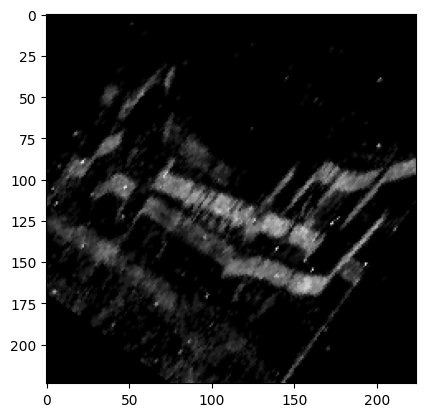

tensor(0.8586)


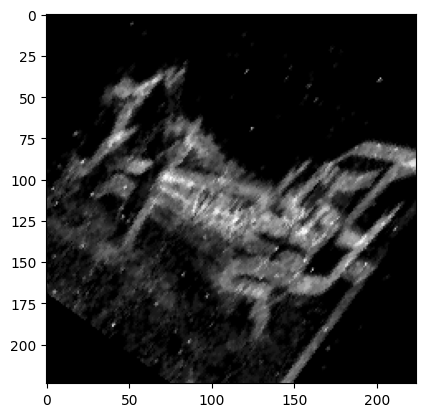

tensor(0.9950)


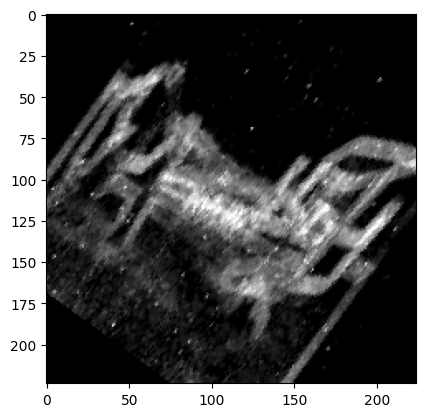

tensor(1.)


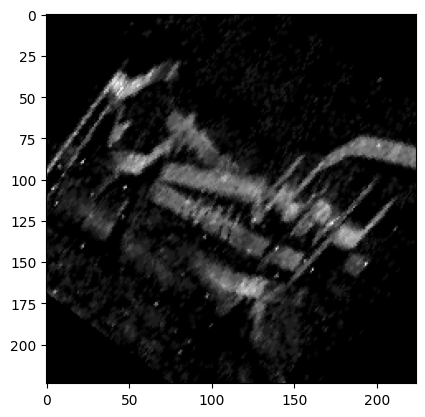

tensor(0.9062)


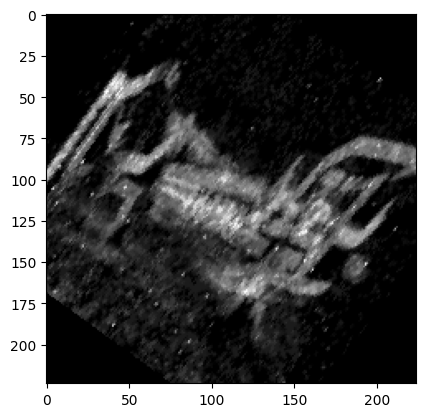

tensor(0.9458)


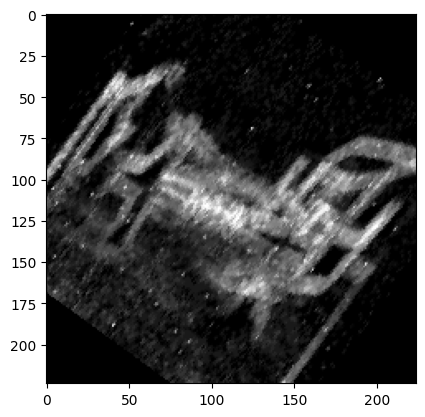

tensor(1.)


In [4]:
pic, label = training_data[100]

noBins = 3
for i in range(2*noBins):
    pic2 = pic[i,...]
    plt.gray()
    plt.imshow(pic2)
    plt.show()
    print(torch.max(pic2))

In [5]:
train_dataset, test_dataset = torch.utils.data.random_split(training_data, [0.8, 0.2])

In [6]:
from torch.utils.data import WeightedRandomSampler
train_dataset.dataset.set_stage(1)
class_sample_count = np.zeros(101)
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    class_sample_count[np.argmax(label)] += 1

weight = 1. / class_sample_count
samples_weight = np.array([weight[int(np.argmax(train_dataset[t][1]))] for t in range(len(train_dataset))])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [7]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=0.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x,min_val=0, max_val=1)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x# F.hardtanh(x)
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet_nCaltech101_ReLU1_ReLUmaxpool_EST__FC2_corrected_exp.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h


# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
#         super(ResidualBlock, self).__init__()
#         if(downsample is not None):
#             self.conv1 = nn.Sequential(
#                             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
#                             nn.BatchNorm2d(out_channels),
#                             nn.ReLU(inplace=False),
#                             nn.MaxPool2d(kernel_size=2, stride=2)
#                             )  # Changed inplace to False
#         else:
#             self.conv1 = nn.Sequential(
#                             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
#                             nn.BatchNorm2d(out_channels),
#                             nn.ReLU( inplace=False)
#                             )
#         self.conv2 = nn.Sequential(
#                         nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
#                         nn.BatchNorm2d(out_channels),
#                         nn.ReLU( inplace=False))  # Changed inplace to False
#         self.downsample = downsample
#         self.relu = nn.ReLU( inplace=False)  # Changed inplace to False
#         self.out_channels = out_channels
#         self.end_maxpool = end_maxpool

#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.conv2(out)
#         if self.downsample:
#             residual = self.downsample(x)
#         out = out + residual
#         if self.end_maxpool:
#             out = F.relu(out, inplace=False)
#         else:
#             out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, layers, num_classes = 2, in_channels = 5):
#         super(ResNet, self).__init__()
#         self.inplanes = 64
#         self.conv1 = nn.Sequential(
#                         nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
#                         nn.BatchNorm2d(64),
#                         nn.ReLU(inplace=False))
#         self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
#         self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
#         self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
#         self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
#         self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
#         self.avgpool = nn.MaxPool2d(7, stride=1)
#         self.fc = nn.Linear(512, 256)
#         self.fc2 = nn.Linear(256, num_classes)
#         self.dropout = nn.Dropout(0.2)

#     def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
#         downsample = None
#         if stride != 1 or self.inplanes != planes:

#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
#                 nn.BatchNorm2d(planes),
#                 nn.ReLU(inplace=False),
#                 nn.MaxPool2d(kernel_size=2, stride=2)
#             )
#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes
#         for i in range(1, blocks):
#             if i == blocks-1 and end_maxpool:
#                 layers.append(block(self.inplanes, planes, end_maxpool = True))
#             else:
#                 layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.maxpool(x)
#         x = self.layer0(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         x = F.hardtanh(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x# F.hardtanh(x)
    
#     def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
#         best_accuracy = 0.0
#         total_step = len(train_loader)
#         # Loss and optimizer
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#         for epoch in range(num_epochs):
#             # self.train()
#             correct = 0
#             total = 0
#             running_loss = 0.0
#             train_loader.dataset.dataset.set_stage(0)
#             for i, (images, labels) in enumerate(tqdm(train_loader)):
#                 # Move tensors to the configured device
#                 images = images.float().to("cuda")
#                 labels = labels.type(torch.FloatTensor)
#                 labels = labels.to("cuda")


#                 optimizer.zero_grad()

#                 # Forward pass
#                 outputs = self.forward(images)
#                 loss = criterion(outputs, labels)
#                 # Backward and optimize
#                 loss.backward()
                
#                 optimizer.step()

#                 # accuracy
#                 _, predicted = torch.max(outputs.data, 1)
#                 correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
#                 total += labels.size(0)
#                 running_loss += loss.item()
#                 del images, labels, outputs

#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
#                             .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))


#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()

#             # Validation
#             with torch.no_grad():
#                 correct = 0
#                 total = 0
#                 val_loss = 0.0
#                 valid_loader.dataset.dataset.set_stage(1)
#                 for images, labels in valid_loader:
#                     images = images.float().to("cuda")
#                     labels = labels.type(torch.FloatTensor)
#                     labels = labels.to("cuda")
#                     outputs = self.forward(images)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
#                     loss = criterion(outputs, labels)
#                     val_loss += loss.item()
#                     del images, labels, outputs
#                 if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
#                     torch.save(self.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST__FC2.pt")

#                 print('Accuracy of the network: {} Loss: {}%'.format( 100 * correct / total, val_loss/len(valid_loader)))

In [9]:
model_resnet = ResNet(ResidualBlock, [5, 6, 6, 4], in_channels = 6, num_classes=101).to("cuda")

In [10]:
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=300, save_best = True, save_thr = 0.48)

100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [1/300], Step [109/109], Loss: 5.0371, Accuracy: 0.0111
Accuracy of the network: 1.3785180930499712 Loss: 4.6170188903808596%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [2/300], Step [109/109], Loss: 4.5273, Accuracy: 0.0198
Accuracy of the network: 1.263641585295807 Loss: 4.496219565651634%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [3/300], Step [109/109], Loss: 4.4381, Accuracy: 0.0228
Accuracy of the network: 1.8954623779437105 Loss: 4.52044056112116%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [4/300], Step [109/109], Loss: 4.4001, Accuracy: 0.0240
Accuracy of the network: 2.4124066628374496 Loss: 4.530378688465465%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [5/300], Step [109/109], Loss: 4.3744, Accuracy: 0.0273
Accuracy of the network: 1.3785180930499712 Loss: 4.452901606126265%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [6/300], Step [109/109], Loss: 4.3923, Accuracy: 0.0293
Accuracy of the network: 4.422745548535325 Loss: 4.526710388877175%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [7/300], Step [109/109], Loss: 4.3914, Accuracy: 0.0257
Accuracy of the network: 2.1252153934520392 Loss: 4.43308535489169%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [8/300], Step [109/109], Loss: 4.3744, Accuracy: 0.0300
Accuracy of the network: 3.5611717403790926 Loss: 4.418779373168945%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [9/300], Step [109/109], Loss: 4.3639, Accuracy: 0.0255
Accuracy of the network: 2.5847214244686962 Loss: 4.444388086145574%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [10/300], Step [109/109], Loss: 4.3653, Accuracy: 0.0299
Accuracy of the network: 2.9867892016082713 Loss: 4.415855711156672%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [11/300], Step [109/109], Loss: 4.3799, Accuracy: 0.0257
Accuracy of the network: 1.7805858701895463 Loss: 4.466811448877508%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [12/300], Step [109/109], Loss: 4.3611, Accuracy: 0.0287
Accuracy of the network: 4.939689833429064 Loss: 4.445586629347368%


100%|██████████| 109/109 [01:00<00:00,  1.80it/s]


Epoch [13/300], Step [109/109], Loss: 4.3505, Accuracy: 0.0349
Accuracy of the network: 2.469844916714532 Loss: 4.485757108168168%


100%|██████████| 109/109 [01:00<00:00,  1.79it/s]


Epoch [14/300], Step [109/109], Loss: 4.3840, Accuracy: 0.0244
Accuracy of the network: 3.1591039632395175 Loss: 4.494992351531982%


100%|██████████| 109/109 [01:15<00:00,  1.44it/s]


Epoch [15/300], Step [109/109], Loss: 4.3695, Accuracy: 0.0293
Accuracy of the network: 1.3785180930499712 Loss: 4.440054460005327%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [16/300], Step [109/109], Loss: 4.3558, Accuracy: 0.0317
Accuracy of the network: 2.010338885697875 Loss: 4.421316025473855%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [17/300], Step [109/109], Loss: 4.3589, Accuracy: 0.0274
Accuracy of the network: 3.5611717403790926 Loss: 4.453217133608732%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [18/300], Step [109/109], Loss: 4.3556, Accuracy: 0.0309
Accuracy of the network: 2.469844916714532 Loss: 4.423191243951971%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [19/300], Step [109/109], Loss: 4.3344, Accuracy: 0.0330
Accuracy of the network: 3.388856978747846 Loss: 4.417840524153276%


100%|██████████| 109/109 [01:21<00:00,  1.33it/s]


Epoch [20/300], Step [109/109], Loss: 4.3362, Accuracy: 0.0333
Accuracy of the network: 1.4359563469270533 Loss: 4.4211274493824355%


100%|██████████| 109/109 [01:21<00:00,  1.33it/s]


Epoch [21/300], Step [109/109], Loss: 4.3472, Accuracy: 0.0267
Accuracy of the network: 4.939689833429064 Loss: 4.43718393499201%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [22/300], Step [109/109], Loss: 4.3394, Accuracy: 0.0260
Accuracy of the network: 2.2975301550832854 Loss: 4.432569945942272%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [23/300], Step [109/109], Loss: 4.3336, Accuracy: 0.0352
Accuracy of the network: 2.469844916714532 Loss: 4.400802889737216%


100%|██████████| 109/109 [01:21<00:00,  1.33it/s]


Epoch [24/300], Step [109/109], Loss: 4.3338, Accuracy: 0.0330
Accuracy of the network: 4.02067777139575 Loss: 4.37987324107777%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [25/300], Step [109/109], Loss: 4.2913, Accuracy: 0.0357
Accuracy of the network: 1.7805858701895463 Loss: 4.3338221029801804%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [26/300], Step [109/109], Loss: 4.2610, Accuracy: 0.0356
Accuracy of the network: 1.8954623779437105 Loss: 4.27150523445823%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [27/300], Step [109/109], Loss: 4.2195, Accuracy: 0.0383
Accuracy of the network: 1.3785180930499712 Loss: 4.391516962918368%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [28/300], Step [109/109], Loss: 4.1823, Accuracy: 0.0385
Accuracy of the network: 3.2165422171166 Loss: 4.265101571516557%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [29/300], Step [109/109], Loss: 4.1275, Accuracy: 0.0479
Accuracy of the network: 4.939689833429064 Loss: 4.112549461017956%


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Epoch [30/300], Step [109/109], Loss: 4.0837, Accuracy: 0.0494
Accuracy of the network: 5.456634118322803 Loss: 4.0374485145915635%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [31/300], Step [109/109], Loss: 4.0358, Accuracy: 0.0616
Accuracy of the network: 5.399195864445721 Loss: 3.978764399615201%


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Epoch [32/300], Step [109/109], Loss: 4.0095, Accuracy: 0.0629
Accuracy of the network: 5.686387133831132 Loss: 3.9608277450908314%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [33/300], Step [109/109], Loss: 3.9859, Accuracy: 0.0639
Accuracy of the network: 5.284319356691556 Loss: 3.992598381909457%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [34/300], Step [109/109], Loss: 3.9561, Accuracy: 0.0708
Accuracy of the network: 4.480183802412407 Loss: 3.968966683474454%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [35/300], Step [109/109], Loss: 3.9188, Accuracy: 0.0768
Accuracy of the network: 10.281447443997703 Loss: 3.8285625154321843%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [36/300], Step [109/109], Loss: 3.8827, Accuracy: 0.0857
Accuracy of the network: 12.923607122343482 Loss: 3.7944148323752662%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [37/300], Step [109/109], Loss: 3.8289, Accuracy: 0.0916
Accuracy of the network: 17.46122917863297 Loss: 3.7522337436676025%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [38/300], Step [109/109], Loss: 3.8127, Accuracy: 0.0917
Accuracy of the network: 12.808730614589317 Loss: 3.858656579797918%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [39/300], Step [109/109], Loss: 3.7883, Accuracy: 0.1035
Accuracy of the network: 19.64388282596209 Loss: 3.640897026928988%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [40/300], Step [109/109], Loss: 3.7421, Accuracy: 0.1115
Accuracy of the network: 8.32854681217691 Loss: 3.8708471861752596%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [41/300], Step [109/109], Loss: 3.7032, Accuracy: 0.1230
Accuracy of the network: 22.228604250430788 Loss: 3.540533937107433%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [42/300], Step [109/109], Loss: 3.6780, Accuracy: 0.1254
Accuracy of the network: 14.589316484778863 Loss: 3.596247538653287%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [43/300], Step [109/109], Loss: 3.6285, Accuracy: 0.1322
Accuracy of the network: 16.36990235496841 Loss: 3.5446155851537533%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [44/300], Step [109/109], Loss: 3.6051, Accuracy: 0.1411
Accuracy of the network: 15.04882251579552 Loss: 3.574046087265015%


100%|██████████| 109/109 [01:22<00:00,  1.33it/s]


Epoch [45/300], Step [109/109], Loss: 3.5999, Accuracy: 0.1442
Accuracy of the network: 22.400919012062033 Loss: 3.474577795375477%


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Epoch [46/300], Step [109/109], Loss: 3.5685, Accuracy: 0.1554
Accuracy of the network: 19.87363584147042 Loss: 3.491418578407981%


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Epoch [47/300], Step [109/109], Loss: 3.5291, Accuracy: 0.1589
Accuracy of the network: 13.038483630097645 Loss: 3.647337514703924%


100%|██████████| 109/109 [01:14<00:00,  1.47it/s]


Epoch [48/300], Step [109/109], Loss: 3.5055, Accuracy: 0.1602
Accuracy of the network: 17.059161401493395 Loss: 3.479372397336093%


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]


Epoch [49/300], Step [109/109], Loss: 3.5078, Accuracy: 0.1569
Accuracy of the network: 20.333141872487076 Loss: 3.450581589612094%


100%|██████████| 109/109 [01:01<00:00,  1.76it/s]


Epoch [50/300], Step [109/109], Loss: 3.4783, Accuracy: 0.1633
Accuracy of the network: 14.53187823090178 Loss: 3.503489975495772%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [51/300], Step [109/109], Loss: 3.4576, Accuracy: 0.1715
Accuracy of the network: 21.02240091901206 Loss: 3.4057404734871604%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [52/300], Step [109/109], Loss: 3.3819, Accuracy: 0.1884
Accuracy of the network: 20.50545663411832 Loss: 3.4012743039564652%


100%|██████████| 109/109 [01:03<00:00,  1.73it/s]


Epoch [53/300], Step [109/109], Loss: 3.3788, Accuracy: 0.1880
Accuracy of the network: 22.515795519816198 Loss: 3.2951286966150457%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [54/300], Step [109/109], Loss: 3.3429, Accuracy: 0.1982
Accuracy of the network: 22.515795519816198 Loss: 3.309018525210294%


100%|██████████| 109/109 [01:02<00:00,  1.74it/s]


Epoch [55/300], Step [109/109], Loss: 3.3282, Accuracy: 0.2055
Accuracy of the network: 18.609994256174613 Loss: 3.3436589154330165%


100%|██████████| 109/109 [01:27<00:00,  1.25it/s]


Epoch [56/300], Step [109/109], Loss: 3.3043, Accuracy: 0.2055
Accuracy of the network: 25.27283170591614 Loss: 3.2339137770912862%


100%|██████████| 109/109 [01:20<00:00,  1.36it/s]


Epoch [57/300], Step [109/109], Loss: 3.2696, Accuracy: 0.2131
Accuracy of the network: 25.330269959793224 Loss: 3.1822464075955477%


100%|██████████| 109/109 [01:28<00:00,  1.23it/s]


Epoch [58/300], Step [109/109], Loss: 3.2689, Accuracy: 0.2069
Accuracy of the network: 23.262492820218267 Loss: 3.1951424338600853%


100%|██████████| 109/109 [01:15<00:00,  1.45it/s]


Epoch [59/300], Step [109/109], Loss: 3.2331, Accuracy: 0.2214
Accuracy of the network: 23.779437105112006 Loss: 3.263307072899558%


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Epoch [60/300], Step [109/109], Loss: 3.2061, Accuracy: 0.2236
Accuracy of the network: 28.25962090752441 Loss: 3.0789097005670722%


100%|██████████| 109/109 [01:10<00:00,  1.55it/s]

Epoch [61/300], Step [109/109], Loss: 3.2023, Accuracy: 0.2272


Accuracy of the network: 25.7323377369328 Loss: 3.1350967623970725%


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Epoch [62/300], Step [109/109], Loss: 3.2103, Accuracy: 0.2299
Accuracy of the network: 27.512923607122342 Loss: 3.158197524330833%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [63/300], Step [109/109], Loss: 3.2049, Accuracy: 0.2262
Accuracy of the network: 26.421596783457783 Loss: 3.1287176739085805%


100%|██████████| 109/109 [01:26<00:00,  1.25it/s]


Epoch [64/300], Step [109/109], Loss: 3.1534, Accuracy: 0.2444
Accuracy of the network: 21.137277426766225 Loss: 3.1352172721516003%


100%|██████████| 109/109 [01:25<00:00,  1.27it/s]


Epoch [65/300], Step [109/109], Loss: 3.1237, Accuracy: 0.2477
Accuracy of the network: 30.212521539345204 Loss: 3.0618593259291216%


100%|██████████| 109/109 [01:19<00:00,  1.36it/s]


Epoch [66/300], Step [109/109], Loss: 3.1102, Accuracy: 0.2382
Accuracy of the network: 23.147616312464102 Loss: 3.1848472291773016%


100%|██████████| 109/109 [01:28<00:00,  1.23it/s]


Epoch [67/300], Step [109/109], Loss: 3.1232, Accuracy: 0.2522
Accuracy of the network: 23.492245835726592 Loss: 3.126850444620306%


100%|██████████| 109/109 [01:15<00:00,  1.45it/s]


Epoch [68/300], Step [109/109], Loss: 3.1004, Accuracy: 0.2500
Accuracy of the network: 24.583572659391155 Loss: 3.1455323566089977%


100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


Epoch [69/300], Step [109/109], Loss: 3.0602, Accuracy: 0.2633
Accuracy of the network: 31.591039632395177 Loss: 2.9682996186343105%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [70/300], Step [109/109], Loss: 3.0327, Accuracy: 0.2735
Accuracy of the network: 28.087306145893166 Loss: 3.0950664390217173%


100%|██████████| 109/109 [01:18<00:00,  1.39it/s]


Epoch [71/300], Step [109/109], Loss: 3.0499, Accuracy: 0.2648
Accuracy of the network: 30.786904078116024 Loss: 2.965092182159424%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [72/300], Step [109/109], Loss: 3.0396, Accuracy: 0.2661
Accuracy of the network: 26.249282021826538 Loss: 3.0036912094463%


100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


Epoch [73/300], Step [109/109], Loss: 2.9986, Accuracy: 0.2847
Accuracy of the network: 26.134405514072373 Loss: 3.054939317703247%


100%|██████████| 109/109 [01:23<00:00,  1.30it/s]


Epoch [74/300], Step [109/109], Loss: 2.9736, Accuracy: 0.2807
Accuracy of the network: 25.78977599080988 Loss: 3.094885136864402%


100%|██████████| 109/109 [01:26<00:00,  1.26it/s]


Epoch [75/300], Step [109/109], Loss: 2.9687, Accuracy: 0.2827
Accuracy of the network: 27.972429638139 Loss: 2.962140503796664%


100%|██████████| 109/109 [00:59<00:00,  1.83it/s]


Epoch [76/300], Step [109/109], Loss: 2.9465, Accuracy: 0.2918
Accuracy of the network: 28.144744399770246 Loss: 2.986504741148515%


100%|██████████| 109/109 [00:58<00:00,  1.88it/s]


Epoch [77/300], Step [109/109], Loss: 2.9317, Accuracy: 0.2880
Accuracy of the network: 25.27283170591614 Loss: 3.0187478455630217%


100%|██████████| 109/109 [00:57<00:00,  1.88it/s]


Epoch [78/300], Step [109/109], Loss: 2.9381, Accuracy: 0.2900
Accuracy of the network: 25.27283170591614 Loss: 2.976322971690785%


100%|██████████| 109/109 [00:57<00:00,  1.88it/s]


Epoch [79/300], Step [109/109], Loss: 2.9053, Accuracy: 0.2943
Accuracy of the network: 28.48937392303274 Loss: 2.960613099011508%


100%|██████████| 109/109 [00:58<00:00,  1.87it/s]


Epoch [80/300], Step [109/109], Loss: 2.8744, Accuracy: 0.3073
Accuracy of the network: 30.61458931648478 Loss: 2.939725641770796%


100%|██████████| 109/109 [00:58<00:00,  1.87it/s]


Epoch [81/300], Step [109/109], Loss: 2.8698, Accuracy: 0.3040
Accuracy of the network: 28.20218265364733 Loss: 2.958827239816839%


100%|██████████| 109/109 [00:57<00:00,  1.88it/s]


Epoch [82/300], Step [109/109], Loss: 2.8927, Accuracy: 0.3004
Accuracy of the network: 32.28029867892016 Loss: 2.854355153170499%


100%|██████████| 109/109 [00:58<00:00,  1.88it/s]


Epoch [83/300], Step [109/109], Loss: 2.8805, Accuracy: 0.3031
Accuracy of the network: 30.38483630097645 Loss: 2.8813647183504973%


100%|██████████| 109/109 [00:58<00:00,  1.88it/s]


Epoch [84/300], Step [109/109], Loss: 2.8797, Accuracy: 0.3111
Accuracy of the network: 27.857553130384836 Loss: 2.960019592805342%


100%|██████████| 109/109 [00:57<00:00,  1.89it/s]


Epoch [85/300], Step [109/109], Loss: 2.8246, Accuracy: 0.3202
Accuracy of the network: 28.02986789201608 Loss: 2.86993558623574%


100%|██████████| 109/109 [00:58<00:00,  1.87it/s]


Epoch [86/300], Step [109/109], Loss: 2.8162, Accuracy: 0.3183
Accuracy of the network: 31.99310740953475 Loss: 2.8877126130190764%


100%|██████████| 109/109 [00:57<00:00,  1.88it/s]


Epoch [87/300], Step [109/109], Loss: 2.8046, Accuracy: 0.3275
Accuracy of the network: 31.188971855255602 Loss: 2.924333030527288%


100%|██████████| 109/109 [00:57<00:00,  1.88it/s]


Epoch [88/300], Step [109/109], Loss: 2.7811, Accuracy: 0.3341
Accuracy of the network: 28.661688684663986 Loss: 2.8790918133475563%


100%|██████████| 109/109 [00:57<00:00,  1.88it/s]


Epoch [89/300], Step [109/109], Loss: 2.7978, Accuracy: 0.3199
Accuracy of the network: 33.25674899483056 Loss: 2.8595314806157894%


100%|██████████| 109/109 [00:57<00:00,  1.88it/s]


Epoch [90/300], Step [109/109], Loss: 2.7801, Accuracy: 0.3255
Accuracy of the network: 32.85468121769098 Loss: 2.883976173400879%


100%|██████████| 109/109 [00:58<00:00,  1.88it/s]


Epoch [91/300], Step [109/109], Loss: 2.7703, Accuracy: 0.3384
Accuracy of the network: 37.162550258472145 Loss: 2.7802875518798826%


100%|██████████| 109/109 [00:57<00:00,  1.88it/s]


Epoch [92/300], Step [109/109], Loss: 2.7801, Accuracy: 0.3377
Accuracy of the network: 26.995979322228603 Loss: 2.9543550578030673%


100%|██████████| 109/109 [01:13<00:00,  1.48it/s]


Epoch [93/300], Step [109/109], Loss: 2.7326, Accuracy: 0.3496
Accuracy of the network: 31.763354394026422 Loss: 2.8929678916931154%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [94/300], Step [109/109], Loss: 2.7483, Accuracy: 0.3394
Accuracy of the network: 30.557151062607698 Loss: 2.832676666433161%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [95/300], Step [109/109], Loss: 2.7220, Accuracy: 0.3453
Accuracy of the network: 34.11832280298679 Loss: 2.74565167427063%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [96/300], Step [109/109], Loss: 2.7435, Accuracy: 0.3385
Accuracy of the network: 32.45261344055141 Loss: 2.8193282387473366%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [97/300], Step [109/109], Loss: 2.6854, Accuracy: 0.3581
Accuracy of the network: 35.841470419299256 Loss: 2.729789638519287%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [98/300], Step [109/109], Loss: 2.6822, Accuracy: 0.3540
Accuracy of the network: 34.34807581849512 Loss: 2.7264259164983575%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [99/300], Step [109/109], Loss: 2.6917, Accuracy: 0.3572
Accuracy of the network: 34.17576105686387 Loss: 2.818741937117143%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [100/300], Step [109/109], Loss: 2.6388, Accuracy: 0.3767
Accuracy of the network: 32.33773693279724 Loss: 2.842384940927679%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [101/300], Step [109/109], Loss: 2.6520, Accuracy: 0.3579
Accuracy of the network: 31.418724870763928 Loss: 2.8171520493247293%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [102/300], Step [109/109], Loss: 2.6160, Accuracy: 0.3670
Accuracy of the network: 33.08443423319931 Loss: 2.7515862248160623%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [103/300], Step [109/109], Loss: 2.6400, Accuracy: 0.3664
Accuracy of the network: 29.5807007466973 Loss: 2.8340841726823287%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [104/300], Step [109/109], Loss: 2.6083, Accuracy: 0.3697
Accuracy of the network: 34.97989661114302 Loss: 2.693769663030451%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [105/300], Step [109/109], Loss: 2.6390, Accuracy: 0.3753
Accuracy of the network: 35.26708788052843 Loss: 2.7126207611777566%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [106/300], Step [109/109], Loss: 2.6097, Accuracy: 0.3754
Accuracy of the network: 35.09477311889719 Loss: 2.6549952810460873%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [107/300], Step [109/109], Loss: 2.6181, Accuracy: 0.3772
Accuracy of the network: 36.186099942561746 Loss: 2.717741766842929%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [108/300], Step [109/109], Loss: 2.6092, Accuracy: 0.3817
Accuracy of the network: 32.62492820218265 Loss: 2.774443513696844%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [109/300], Step [109/109], Loss: 2.5965, Accuracy: 0.3766
Accuracy of the network: 35.20964962665135 Loss: 2.6264301906932483%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [110/300], Step [109/109], Loss: 2.5734, Accuracy: 0.3866
Accuracy of the network: 34.97989661114302 Loss: 2.694439545544711%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [111/300], Step [109/109], Loss: 2.5608, Accuracy: 0.3892
Accuracy of the network: 38.48363009764503 Loss: 2.66856520392678%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [112/300], Step [109/109], Loss: 2.5475, Accuracy: 0.3960
Accuracy of the network: 36.473291211947156 Loss: 2.6470598177476363%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [113/300], Step [109/109], Loss: 2.5387, Accuracy: 0.3962
Accuracy of the network: 32.68236645605974 Loss: 2.760296093333851%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [114/300], Step [109/109], Loss: 2.5025, Accuracy: 0.4030
Accuracy of the network: 35.66915565766801 Loss: 2.662833820689808%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [115/300], Step [109/109], Loss: 2.5138, Accuracy: 0.4070
Accuracy of the network: 36.30097645031591 Loss: 2.664134571769021%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [116/300], Step [109/109], Loss: 2.5001, Accuracy: 0.4066
Accuracy of the network: 35.66915565766801 Loss: 2.670025669444691%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [117/300], Step [109/109], Loss: 2.4949, Accuracy: 0.4049
Accuracy of the network: 36.760482481332566 Loss: 2.622459975155917%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [118/300], Step [109/109], Loss: 2.5082, Accuracy: 0.4034
Accuracy of the network: 37.162550258472145 Loss: 2.6587856336073443%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [119/300], Step [109/109], Loss: 2.4483, Accuracy: 0.4182
Accuracy of the network: 36.53072946582424 Loss: 2.6517692045731978%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [120/300], Step [109/109], Loss: 2.4608, Accuracy: 0.4176
Accuracy of the network: 35.03733486502011 Loss: 2.6719189470464535%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [121/300], Step [109/109], Loss: 2.4552, Accuracy: 0.4130
Accuracy of the network: 32.73980470993682 Loss: 2.721512269973755%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [122/300], Step [109/109], Loss: 2.4006, Accuracy: 0.4267
Accuracy of the network: 34.69270534175761 Loss: 2.65179744200273%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [123/300], Step [109/109], Loss: 2.4225, Accuracy: 0.4181
Accuracy of the network: 36.24353819643883 Loss: 2.617429880662398%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [124/300], Step [109/109], Loss: 2.3967, Accuracy: 0.4331
Accuracy of the network: 39.862148190695 Loss: 2.5567806634035977%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [125/300], Step [109/109], Loss: 2.3903, Accuracy: 0.4229
Accuracy of the network: 36.0137851809305 Loss: 2.6300002098083497%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [126/300], Step [109/109], Loss: 2.3874, Accuracy: 0.4353
Accuracy of the network: 38.828259620907524 Loss: 2.569570207595825%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [127/300], Step [109/109], Loss: 2.3911, Accuracy: 0.4334
Accuracy of the network: 38.541068351522114 Loss: 2.6279878919774835%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [128/300], Step [109/109], Loss: 2.3749, Accuracy: 0.4370
Accuracy of the network: 38.71338311315336 Loss: 2.5651239265095103%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [129/300], Step [109/109], Loss: 2.3702, Accuracy: 0.4396
Accuracy of the network: 38.828259620907524 Loss: 2.570340598713268%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [130/300], Step [109/109], Loss: 2.3416, Accuracy: 0.4466
Accuracy of the network: 41.01091326823664 Loss: 2.5240504611622203%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [131/300], Step [109/109], Loss: 2.3245, Accuracy: 0.4551
Accuracy of the network: 41.75761056863871 Loss: 2.501289280978116%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [132/300], Step [109/109], Loss: 2.3434, Accuracy: 0.4412
Accuracy of the network: 34.97989661114302 Loss: 2.6097501624714243%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [133/300], Step [109/109], Loss: 2.2982, Accuracy: 0.4519
Accuracy of the network: 40.60884549109707 Loss: 2.529431135004217%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [134/300], Step [109/109], Loss: 2.2820, Accuracy: 0.4522
Accuracy of the network: 35.20964962665135 Loss: 2.652418864857067%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [135/300], Step [109/109], Loss: 2.2838, Accuracy: 0.4558
Accuracy of the network: 40.26421596783458 Loss: 2.46936036456715%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [136/300], Step [109/109], Loss: 2.2963, Accuracy: 0.4591
Accuracy of the network: 41.06835152211373 Loss: 2.4765350861982864%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [137/300], Step [109/109], Loss: 2.2643, Accuracy: 0.4623
Accuracy of the network: 43.02125215393452 Loss: 2.4227843024513938%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [138/300], Step [109/109], Loss: 2.2877, Accuracy: 0.4601
Accuracy of the network: 39.172889144170014 Loss: 2.5484604011882435%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [139/300], Step [109/109], Loss: 2.2676, Accuracy: 0.4601
Accuracy of the network: 43.02125215393452 Loss: 2.4463403528386896%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [140/300], Step [109/109], Loss: 2.2278, Accuracy: 0.4709
Accuracy of the network: 38.94313612866169 Loss: 2.515276306325739%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [141/300], Step [109/109], Loss: 2.2374, Accuracy: 0.4745
Accuracy of the network: 41.01091326823664 Loss: 2.4939599470658735%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [142/300], Step [109/109], Loss: 2.2187, Accuracy: 0.4737
Accuracy of the network: 42.04480183802412 Loss: 2.4641728834672407%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [143/300], Step [109/109], Loss: 2.2176, Accuracy: 0.4779
Accuracy of the network: 43.25100516944285 Loss: 2.3956271453337235%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [144/300], Step [109/109], Loss: 2.1898, Accuracy: 0.4889
Accuracy of the network: 42.90637564618036 Loss: 2.421703069860285%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [145/300], Step [109/109], Loss: 2.2066, Accuracy: 0.4803
Accuracy of the network: 39.97702469844917 Loss: 2.4939067472111094%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [146/300], Step [109/109], Loss: 2.1652, Accuracy: 0.4934
Accuracy of the network: 38.655944859276275 Loss: 2.486515066840432%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [147/300], Step [109/109], Loss: 2.1877, Accuracy: 0.4834
Accuracy of the network: 43.19356691556577 Loss: 2.4150619073347612%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [148/300], Step [109/109], Loss: 2.1684, Accuracy: 0.4813
Accuracy of the network: 42.04480183802412 Loss: 2.449845704165372%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [149/300], Step [109/109], Loss: 2.1603, Accuracy: 0.4865
Accuracy of the network: 43.02125215393452 Loss: 2.4268772081895307%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [150/300], Step [109/109], Loss: 2.1489, Accuracy: 0.4933
Accuracy of the network: 42.38943136128662 Loss: 2.4379825722087514%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [151/300], Step [109/109], Loss: 2.1355, Accuracy: 0.4981
Accuracy of the network: 40.78116025272832 Loss: 2.439738481695002%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [152/300], Step [109/109], Loss: 2.1476, Accuracy: 0.4900
Accuracy of the network: 43.4233199310741 Loss: 2.3853075872768055%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [153/300], Step [109/109], Loss: 2.1443, Accuracy: 0.4930
Accuracy of the network: 40.32165422171166 Loss: 2.462602307579734%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [154/300], Step [109/109], Loss: 2.1273, Accuracy: 0.4957
Accuracy of the network: 41.92992533026996 Loss: 2.4544049609791148%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [155/300], Step [109/109], Loss: 2.1183, Accuracy: 0.5034
Accuracy of the network: 43.65307294658243 Loss: 2.3910266095941717%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [156/300], Step [109/109], Loss: 2.0869, Accuracy: 0.5111
Accuracy of the network: 43.94026421596784 Loss: 2.3980942487716677%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [157/300], Step [109/109], Loss: 2.0779, Accuracy: 0.5154
Accuracy of the network: 42.38943136128662 Loss: 2.4042502013119784%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [158/300], Step [109/109], Loss: 2.0970, Accuracy: 0.5043
Accuracy of the network: 44.170017231476166 Loss: 2.339599108695984%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [159/300], Step [109/109], Loss: 2.0797, Accuracy: 0.5067
Accuracy of the network: 43.76794945433659 Loss: 2.39790068322962%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [160/300], Step [109/109], Loss: 2.0889, Accuracy: 0.5059
Accuracy of the network: 42.50430786904078 Loss: 2.4194138570265338%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [161/300], Step [109/109], Loss: 2.0466, Accuracy: 0.5217
Accuracy of the network: 43.82538770821367 Loss: 2.3646893804723566%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [162/300], Step [109/109], Loss: 2.0615, Accuracy: 0.5086
Accuracy of the network: 43.82538770821367 Loss: 2.3943726496262983%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [163/300], Step [109/109], Loss: 2.0682, Accuracy: 0.5151
Accuracy of the network: 43.882825962090756 Loss: 2.3598291288722644%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [164/300], Step [109/109], Loss: 2.0323, Accuracy: 0.5228
Accuracy of the network: 43.882825962090756 Loss: 2.389208097891374%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [165/300], Step [109/109], Loss: 2.0199, Accuracy: 0.5270
Accuracy of the network: 40.60884549109707 Loss: 2.441763938557018%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [166/300], Step [109/109], Loss: 1.9947, Accuracy: 0.5253
Accuracy of the network: 44.39977024698449 Loss: 2.349553871154785%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [167/300], Step [109/109], Loss: 2.0276, Accuracy: 0.5144
Accuracy of the network: 42.21711659965537 Loss: 2.3659881288355047%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [168/300], Step [109/109], Loss: 2.0057, Accuracy: 0.5343
Accuracy of the network: 45.43365881677197 Loss: 2.315800187804482%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [169/300], Step [109/109], Loss: 1.9853, Accuracy: 0.5339
Accuracy of the network: 44.39977024698449 Loss: 2.3755964105779475%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [170/300], Step [109/109], Loss: 1.9693, Accuracy: 0.5400
Accuracy of the network: 42.04480183802412 Loss: 2.402551195838235%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [171/300], Step [109/109], Loss: 1.9526, Accuracy: 0.5425
Accuracy of the network: 43.76794945433659 Loss: 2.3757105285471134%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [172/300], Step [109/109], Loss: 1.9619, Accuracy: 0.5413
Accuracy of the network: 43.882825962090756 Loss: 2.3361650358546866%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [173/300], Step [109/109], Loss: 1.9234, Accuracy: 0.5527
Accuracy of the network: 44.514646754738656 Loss: 2.3747545870867643%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [174/300], Step [109/109], Loss: 1.9459, Accuracy: 0.5413
Accuracy of the network: 46.065479609419874 Loss: 2.3217369708147917%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [175/300], Step [109/109], Loss: 1.9216, Accuracy: 0.5515
Accuracy of the network: 45.548535324526135 Loss: 2.2716636939482258%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [176/300], Step [109/109], Loss: 1.9283, Accuracy: 0.5409
Accuracy of the network: 45.835726593911545 Loss: 2.3077055194161153%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [177/300], Step [109/109], Loss: 1.9025, Accuracy: 0.5534
Accuracy of the network: 44.744399770246986 Loss: 2.303829242966392%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [178/300], Step [109/109], Loss: 1.8795, Accuracy: 0.5634
Accuracy of the network: 44.34233199310741 Loss: 2.324181008338928%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [179/300], Step [109/109], Loss: 1.8903, Accuracy: 0.5577
Accuracy of the network: 46.295232624928204 Loss: 2.2667170893062245%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [180/300], Step [109/109], Loss: 1.8709, Accuracy: 0.5578
Accuracy of the network: 44.055140723722 Loss: 2.3484767371957953%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [181/300], Step [109/109], Loss: 1.8999, Accuracy: 0.5532
Accuracy of the network: 44.57208500861574 Loss: 2.315303412350741%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [182/300], Step [109/109], Loss: 1.8576, Accuracy: 0.5702
Accuracy of the network: 43.53819643882826 Loss: 2.3125299670479516%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [183/300], Step [109/109], Loss: 1.8231, Accuracy: 0.5749
Accuracy of the network: 44.744399770246986 Loss: 2.3265870462764395%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [184/300], Step [109/109], Loss: 1.8415, Accuracy: 0.5755
Accuracy of the network: 45.835726593911545 Loss: 2.2697496609254317%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [185/300], Step [109/109], Loss: 1.8183, Accuracy: 0.5791
Accuracy of the network: 46.467547386559445 Loss: 2.264939134771174%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [186/300], Step [109/109], Loss: 1.8045, Accuracy: 0.5850
Accuracy of the network: 46.81217690982194 Loss: 2.223390733111988%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [187/300], Step [109/109], Loss: 1.8248, Accuracy: 0.5741
Accuracy of the network: 45.548535324526135 Loss: 2.299297675219449%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [188/300], Step [109/109], Loss: 1.7857, Accuracy: 0.5875
Accuracy of the network: 47.09936817920735 Loss: 2.244777105071328%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [189/300], Step [109/109], Loss: 1.7990, Accuracy: 0.5781
Accuracy of the network: 45.548535324526135 Loss: 2.2939879547465933%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [190/300], Step [109/109], Loss: 1.7621, Accuracy: 0.5964
Accuracy of the network: 45.031591039632396 Loss: 2.254872200705788%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [191/300], Step [109/109], Loss: 1.7706, Accuracy: 0.5946
Accuracy of the network: 45.893164847788626 Loss: 2.2800740588795056%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [192/300], Step [109/109], Loss: 1.7719, Accuracy: 0.5852
Accuracy of the network: 44.85927627800115 Loss: 2.277146491137418%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [193/300], Step [109/109], Loss: 1.7556, Accuracy: 0.5937
Accuracy of the network: 46.467547386559445 Loss: 2.2266681519421665%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [194/300], Step [109/109], Loss: 1.7427, Accuracy: 0.5930
Accuracy of the network: 46.927053417576104 Loss: 2.2331706350499934%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [195/300], Step [109/109], Loss: 1.7301, Accuracy: 0.5956
Accuracy of the network: 47.67375071797817 Loss: 2.202219254320318%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [196/300], Step [109/109], Loss: 1.7175, Accuracy: 0.6029
Accuracy of the network: 47.501435956346924 Loss: 2.2384171204133465%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [197/300], Step [109/109], Loss: 1.7182, Accuracy: 0.6072
Accuracy of the network: 46.23779437105112 Loss: 2.252544530955228%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [198/300], Step [109/109], Loss: 1.7164, Accuracy: 0.6068
Accuracy of the network: 48.5353245261344 Loss: 2.182096329602328%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [199/300], Step [109/109], Loss: 1.7191, Accuracy: 0.6038
Accuracy of the network: 47.443997702469844 Loss: 2.2037529771978206%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [200/300], Step [109/109], Loss: 1.6693, Accuracy: 0.6128
Accuracy of the network: 48.47788627225732 Loss: 2.199980354309082%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [201/300], Step [109/109], Loss: 1.6689, Accuracy: 0.6151
Accuracy of the network: 46.065479609419874 Loss: 2.2336260188709605%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [202/300], Step [109/109], Loss: 1.6638, Accuracy: 0.6188
Accuracy of the network: 49.56921309592188 Loss: 2.1436193292791192%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [203/300], Step [109/109], Loss: 1.6757, Accuracy: 0.6101
Accuracy of the network: 49.10970706490523 Loss: 2.159657417644154%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [204/300], Step [109/109], Loss: 1.6554, Accuracy: 0.6187
Accuracy of the network: 48.59276278001149 Loss: 2.1642828204415063%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [205/300], Step [109/109], Loss: 1.6489, Accuracy: 0.6206
Accuracy of the network: 47.61631246410109 Loss: 2.189285332506353%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [206/300], Step [109/109], Loss: 1.6378, Accuracy: 0.6231
Accuracy of the network: 47.61631246410109 Loss: 2.2021149136803366%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [207/300], Step [109/109], Loss: 1.6544, Accuracy: 0.6208
Accuracy of the network: 47.731188971855254 Loss: 2.1805864615873856%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [208/300], Step [109/109], Loss: 1.6296, Accuracy: 0.6217
Accuracy of the network: 46.697300402067775 Loss: 2.2285158287395133%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [209/300], Step [109/109], Loss: 1.6092, Accuracy: 0.6320
Accuracy of the network: 47.61631246410109 Loss: 2.2037797169251876%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [210/300], Step [109/109], Loss: 1.6161, Accuracy: 0.6302
Accuracy of the network: 47.61631246410109 Loss: 2.2103535695509477%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [211/300], Step [109/109], Loss: 1.5881, Accuracy: 0.6416
Accuracy of the network: 50.02871912693854 Loss: 2.1428208264437587%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [212/300], Step [109/109], Loss: 1.5744, Accuracy: 0.6455
Accuracy of the network: 49.28202182653647 Loss: 2.1658316417173906%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [213/300], Step [109/109], Loss: 1.5929, Accuracy: 0.6300
Accuracy of the network: 48.42044801838024 Loss: 2.201827465404164%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [214/300], Step [109/109], Loss: 1.5855, Accuracy: 0.6381
Accuracy of the network: 47.731188971855254 Loss: 2.20107110413638%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [215/300], Step [109/109], Loss: 1.5585, Accuracy: 0.6429
Accuracy of the network: 47.78862722573234 Loss: 2.1911804806102406%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [216/300], Step [109/109], Loss: 1.5423, Accuracy: 0.6528
Accuracy of the network: 48.93739230327398 Loss: 2.152710710872303%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [217/300], Step [109/109], Loss: 1.5489, Accuracy: 0.6488
Accuracy of the network: 49.39689833429064 Loss: 2.1151048985394563%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [218/300], Step [109/109], Loss: 1.5245, Accuracy: 0.6550
Accuracy of the network: 46.927053417576104 Loss: 2.2005970109592785%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [219/300], Step [109/109], Loss: 1.5476, Accuracy: 0.6515
Accuracy of the network: 48.70763928776565 Loss: 2.1621304685419256%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [220/300], Step [109/109], Loss: 1.5103, Accuracy: 0.6672
Accuracy of the network: 48.01838024124066 Loss: 2.156132383780046%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [221/300], Step [109/109], Loss: 1.5028, Accuracy: 0.6726
Accuracy of the network: 48.01838024124066 Loss: 2.17592370076613%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [222/300], Step [109/109], Loss: 1.5068, Accuracy: 0.6592
Accuracy of the network: 48.42044801838024 Loss: 2.184257511659102%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [223/300], Step [109/109], Loss: 1.5259, Accuracy: 0.6580
Accuracy of the network: 47.78862722573234 Loss: 2.1608269041234798%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [224/300], Step [109/109], Loss: 1.5092, Accuracy: 0.6579
Accuracy of the network: 48.8799540493969 Loss: 2.1617576707493176%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [225/300], Step [109/109], Loss: 1.4577, Accuracy: 0.6792
Accuracy of the network: 48.70763928776565 Loss: 2.1628360748291016%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [226/300], Step [109/109], Loss: 1.4910, Accuracy: 0.6632
Accuracy of the network: 48.99483055715106 Loss: 2.1453802065415815%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [227/300], Step [109/109], Loss: 1.4770, Accuracy: 0.6705
Accuracy of the network: 49.45433658816772 Loss: 2.1352370500564577%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [228/300], Step [109/109], Loss: 1.4479, Accuracy: 0.6742
Accuracy of the network: 47.443997702469844 Loss: 2.19243512803858%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [229/300], Step [109/109], Loss: 1.4826, Accuracy: 0.6662
Accuracy of the network: 48.93739230327398 Loss: 2.161588074944236%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [230/300], Step [109/109], Loss: 1.4249, Accuracy: 0.6836
Accuracy of the network: 49.68408960367605 Loss: 2.117042443969033%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [231/300], Step [109/109], Loss: 1.4505, Accuracy: 0.6709
Accuracy of the network: 48.59276278001149 Loss: 2.14260715788061%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [232/300], Step [109/109], Loss: 1.4474, Accuracy: 0.6772
Accuracy of the network: 49.45433658816772 Loss: 2.1375413504513827%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [233/300], Step [109/109], Loss: 1.4197, Accuracy: 0.6851
Accuracy of the network: 50.31591039632395 Loss: 2.1157335584813897%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [234/300], Step [109/109], Loss: 1.4168, Accuracy: 0.6820
Accuracy of the network: 51.17748420448019 Loss: 2.102594949982383%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [235/300], Step [109/109], Loss: 1.3877, Accuracy: 0.6950
Accuracy of the network: 50.20103388856979 Loss: 2.116748675433072%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [236/300], Step [109/109], Loss: 1.3946, Accuracy: 0.6993
Accuracy of the network: 51.17748420448019 Loss: 2.087061246958646%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [237/300], Step [109/109], Loss: 1.3877, Accuracy: 0.6959
Accuracy of the network: 49.5117748420448 Loss: 2.102765499461781%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [238/300], Step [109/109], Loss: 1.3923, Accuracy: 0.6939
Accuracy of the network: 50.37334865020103 Loss: 2.093685373392972%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [239/300], Step [109/109], Loss: 1.4001, Accuracy: 0.6953
Accuracy of the network: 49.97128087306146 Loss: 2.1232066696340386%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [240/300], Step [109/109], Loss: 1.3703, Accuracy: 0.7080
Accuracy of the network: 50.08615738081562 Loss: 2.085919696634466%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [241/300], Step [109/109], Loss: 1.3537, Accuracy: 0.7031
Accuracy of the network: 50.54566341183228 Loss: 2.089827036857605%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [242/300], Step [109/109], Loss: 1.3463, Accuracy: 0.7082
Accuracy of the network: 50.25847214244687 Loss: 2.111747312545776%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [243/300], Step [109/109], Loss: 1.3383, Accuracy: 0.7124
Accuracy of the network: 50.02871912693854 Loss: 2.129532534425909%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [244/300], Step [109/109], Loss: 1.3298, Accuracy: 0.7101
Accuracy of the network: 50.66053991958645 Loss: 2.0770455555482346%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [245/300], Step [109/109], Loss: 1.3269, Accuracy: 0.7127
Accuracy of the network: 50.37334865020103 Loss: 2.0900714765895496%


100%|██████████| 109/109 [01:18<00:00,  1.38it/s]


Epoch [246/300], Step [109/109], Loss: 1.3173, Accuracy: 0.7166
Accuracy of the network: 49.97128087306146 Loss: 2.1245974215594203%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [247/300], Step [109/109], Loss: 1.3084, Accuracy: 0.7150
Accuracy of the network: 50.77541642734061 Loss: 2.094691027294506%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [248/300], Step [109/109], Loss: 1.3081, Accuracy: 0.7232
Accuracy of the network: 51.06260769672602 Loss: 2.0717815962704744%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [249/300], Step [109/109], Loss: 1.3367, Accuracy: 0.7081
Accuracy of the network: 50.02871912693854 Loss: 2.1092776341871784%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [250/300], Step [109/109], Loss: 1.3112, Accuracy: 0.7207
Accuracy of the network: 50.25847214244687 Loss: 2.080828991803256%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [251/300], Step [109/109], Loss: 1.2943, Accuracy: 0.7253
Accuracy of the network: 50.4882251579552 Loss: 2.131029230898077%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [252/300], Step [109/109], Loss: 1.3008, Accuracy: 0.7171
Accuracy of the network: 51.17748420448019 Loss: 2.055696526440707%


100%|██████████| 109/109 [01:19<00:00,  1.38it/s]


Epoch [253/300], Step [109/109], Loss: 1.2874, Accuracy: 0.7301
Accuracy of the network: 51.57955198161976 Loss: 2.0589769796891644%


100%|██████████| 109/109 [01:19<00:00,  1.37it/s]


Epoch [254/300], Step [109/109], Loss: 1.2975, Accuracy: 0.7276
Accuracy of the network: 51.29236071223435 Loss: 2.0839882612228395%


100%|██████████| 109/109 [01:28<00:00,  1.24it/s]


Epoch [255/300], Step [109/109], Loss: 1.2497, Accuracy: 0.7365
Accuracy of the network: 49.97128087306146 Loss: 2.1323261282660746%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [256/300], Step [109/109], Loss: 1.2701, Accuracy: 0.7289
Accuracy of the network: 52.0964962665135 Loss: 2.0579871264371006%


100%|██████████| 109/109 [01:17<00:00,  1.41it/s]


Epoch [257/300], Step [109/109], Loss: 1.2567, Accuracy: 0.7351
Accuracy of the network: 50.43078690407812 Loss: 2.1184120178222656%


100%|██████████| 109/109 [01:26<00:00,  1.26it/s]


Epoch [258/300], Step [109/109], Loss: 1.2569, Accuracy: 0.7331
Accuracy of the network: 51.57955198161976 Loss: 2.066915932568637%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [259/300], Step [109/109], Loss: 1.2667, Accuracy: 0.7349
Accuracy of the network: 51.52211372774268 Loss: 2.0593733657490123%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [260/300], Step [109/109], Loss: 1.2333, Accuracy: 0.7421
Accuracy of the network: 51.86674325100517 Loss: 2.0445021109147503%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [261/300], Step [109/109], Loss: 1.2372, Accuracy: 0.7428
Accuracy of the network: 52.61344055140724 Loss: 2.0612377751957287%


100%|██████████| 109/109 [01:27<00:00,  1.24it/s]


Epoch [262/300], Step [109/109], Loss: 1.2183, Accuracy: 0.7497
Accuracy of the network: 51.80930499712809 Loss: 2.059165055101568%


100%|██████████| 109/109 [01:26<00:00,  1.26it/s]


Epoch [263/300], Step [109/109], Loss: 1.2232, Accuracy: 0.7387
Accuracy of the network: 51.63699023549684 Loss: 2.088189289786599%


100%|██████████| 109/109 [01:28<00:00,  1.24it/s]


Epoch [264/300], Step [109/109], Loss: 1.2119, Accuracy: 0.7536
Accuracy of the network: 51.34979896611143 Loss: 2.0627718296918003%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [265/300], Step [109/109], Loss: 1.2152, Accuracy: 0.7428
Accuracy of the network: 51.92418150488225 Loss: 2.0742228442972355%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [266/300], Step [109/109], Loss: 1.2098, Accuracy: 0.7497
Accuracy of the network: 51.17748420448019 Loss: 2.0631514354185625%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [267/300], Step [109/109], Loss: 1.2140, Accuracy: 0.7499
Accuracy of the network: 51.06260769672602 Loss: 2.059482713179155%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [268/300], Step [109/109], Loss: 1.1925, Accuracy: 0.7519
Accuracy of the network: 51.80930499712809 Loss: 2.0454304153268987%


100%|██████████| 109/109 [01:24<00:00,  1.28it/s]


Epoch [269/300], Step [109/109], Loss: 1.2004, Accuracy: 0.7533
Accuracy of the network: 51.98161975875934 Loss: 2.056494613127275%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [270/300], Step [109/109], Loss: 1.1927, Accuracy: 0.7537
Accuracy of the network: 52.15393452039058 Loss: 2.0320641734383322%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [271/300], Step [109/109], Loss: 1.1857, Accuracy: 0.7519
Accuracy of the network: 51.17748420448019 Loss: 2.0683367187326605%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [272/300], Step [109/109], Loss: 1.1721, Accuracy: 0.7612
Accuracy of the network: 52.03905801263642 Loss: 2.066422120007602%


100%|██████████| 109/109 [01:25<00:00,  1.28it/s]


Epoch [273/300], Step [109/109], Loss: 1.1602, Accuracy: 0.7606
Accuracy of the network: 53.015508328546815 Loss: 2.0381214271892203%


100%|██████████| 109/109 [01:23<00:00,  1.31it/s]


Epoch [274/300], Step [109/109], Loss: 1.1708, Accuracy: 0.7557
Accuracy of the network: 51.40723721998851 Loss: 2.0629462957382203%


100%|██████████| 109/109 [00:59<00:00,  1.83it/s]


Epoch [275/300], Step [109/109], Loss: 1.1622, Accuracy: 0.7619
Accuracy of the network: 51.75186674325101 Loss: 2.0604745084589178%


100%|██████████| 109/109 [00:59<00:00,  1.82it/s]


Epoch [276/300], Step [109/109], Loss: 1.1603, Accuracy: 0.7622
Accuracy of the network: 51.98161975875934 Loss: 2.063495042107322%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [277/300], Step [109/109], Loss: 1.1543, Accuracy: 0.7631
Accuracy of the network: 52.95807007466973 Loss: 2.0110916766253384%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [278/300], Step [109/109], Loss: 1.1521, Accuracy: 0.7590
Accuracy of the network: 51.80930499712809 Loss: 2.0433914921500467%


100%|██████████| 109/109 [01:00<00:00,  1.82it/s]


Epoch [279/300], Step [109/109], Loss: 1.1664, Accuracy: 0.7612
Accuracy of the network: 53.130384836300976 Loss: 2.0428658723831177%


100%|██████████| 109/109 [01:00<00:00,  1.81it/s]


Epoch [280/300], Step [109/109], Loss: 1.1151, Accuracy: 0.7770
Accuracy of the network: 51.98161975875934 Loss: 2.0649387988177215%


100%|██████████| 109/109 [00:59<00:00,  1.82it/s]


Epoch [281/300], Step [109/109], Loss: 1.1271, Accuracy: 0.7695
Accuracy of the network: 52.21137277426766 Loss: 2.0408258719877765%


100%|██████████| 109/109 [01:02<00:00,  1.74it/s]


Epoch [282/300], Step [109/109], Loss: 1.1235, Accuracy: 0.7692
Accuracy of the network: 52.556002297530156 Loss: 2.0436619195071133%


100%|██████████| 109/109 [01:01<00:00,  1.76it/s]


Epoch [283/300], Step [109/109], Loss: 1.1334, Accuracy: 0.7704
Accuracy of the network: 51.98161975875934 Loss: 2.0642965056679468%


100%|██████████| 109/109 [01:01<00:00,  1.76it/s]


Epoch [284/300], Step [109/109], Loss: 1.1239, Accuracy: 0.7745
Accuracy of the network: 52.21137277426766 Loss: 2.0559008208188145%


100%|██████████| 109/109 [01:02<00:00,  1.76it/s]


Epoch [285/300], Step [109/109], Loss: 1.1111, Accuracy: 0.7819
Accuracy of the network: 52.44112578977599 Loss: 2.05595281124115%


100%|██████████| 109/109 [01:01<00:00,  1.76it/s]


Epoch [286/300], Step [109/109], Loss: 1.1193, Accuracy: 0.7770
Accuracy of the network: 52.38368753589891 Loss: 2.0344561901959506%


100%|██████████| 109/109 [01:01<00:00,  1.76it/s]


Epoch [287/300], Step [109/109], Loss: 1.1150, Accuracy: 0.7790
Accuracy of the network: 51.98161975875934 Loss: 2.0453604914925316%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [288/300], Step [109/109], Loss: 1.0989, Accuracy: 0.7801
Accuracy of the network: 51.40723721998851 Loss: 2.050973898714239%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [289/300], Step [109/109], Loss: 1.1041, Accuracy: 0.7794
Accuracy of the network: 52.67087880528432 Loss: 2.0099417773160067%


100%|██████████| 109/109 [01:02<00:00,  1.74it/s]


Epoch [290/300], Step [109/109], Loss: 1.0823, Accuracy: 0.7853
Accuracy of the network: 53.072946582423896 Loss: 1.9929512739181519%


100%|██████████| 109/109 [01:02<00:00,  1.75it/s]


Epoch [291/300], Step [109/109], Loss: 1.0864, Accuracy: 0.7810
Accuracy of the network: 51.86674325100517 Loss: 2.040980525450273%


100%|██████████| 109/109 [01:00<00:00,  1.79it/s]


Epoch [292/300], Step [109/109], Loss: 1.0720, Accuracy: 0.7882
Accuracy of the network: 52.32624928202183 Loss: 2.037668776512146%


100%|██████████| 109/109 [01:05<00:00,  1.65it/s]


Epoch [293/300], Step [109/109], Loss: 1.0945, Accuracy: 0.7757
Accuracy of the network: 52.61344055140724 Loss: 2.029973216490312%


100%|██████████| 109/109 [01:02<00:00,  1.73it/s]


Epoch [294/300], Step [109/109], Loss: 1.0835, Accuracy: 0.7843
Accuracy of the network: 52.67087880528432 Loss: 2.014790029959245%


100%|██████████| 109/109 [01:02<00:00,  1.73it/s]


Epoch [295/300], Step [109/109], Loss: 1.0710, Accuracy: 0.7830
Accuracy of the network: 52.44112578977599 Loss: 2.0203998565673826%


100%|██████████| 109/109 [01:02<00:00,  1.73it/s]


Epoch [296/300], Step [109/109], Loss: 1.0663, Accuracy: 0.7899
Accuracy of the network: 52.44112578977599 Loss: 2.0308309186588636%


100%|██████████| 109/109 [01:01<00:00,  1.77it/s]


Epoch [297/300], Step [109/109], Loss: 1.0874, Accuracy: 0.7823
Accuracy of the network: 52.498564043653076 Loss: 2.0297012090682984%


100%|██████████| 109/109 [01:01<00:00,  1.76it/s]


Epoch [298/300], Step [109/109], Loss: 1.0691, Accuracy: 0.7932
Accuracy of the network: 53.015508328546815 Loss: 2.020686223290183%


100%|██████████| 109/109 [01:02<00:00,  1.76it/s]


Epoch [299/300], Step [109/109], Loss: 1.0596, Accuracy: 0.7912
Accuracy of the network: 52.03905801263642 Loss: 2.0358439640565353%


100%|██████████| 109/109 [01:02<00:00,  1.74it/s]


Epoch [300/300], Step [109/109], Loss: 1.0379, Accuracy: 0.8034
Accuracy of the network: 52.67087880528432 Loss: 2.029217832738703%


In [11]:
torch.save(model_resnet, "best_resnet_nCaltech101_ReLU1_ReLUmaxpool_EST_FC2_corrected_exp.pt")

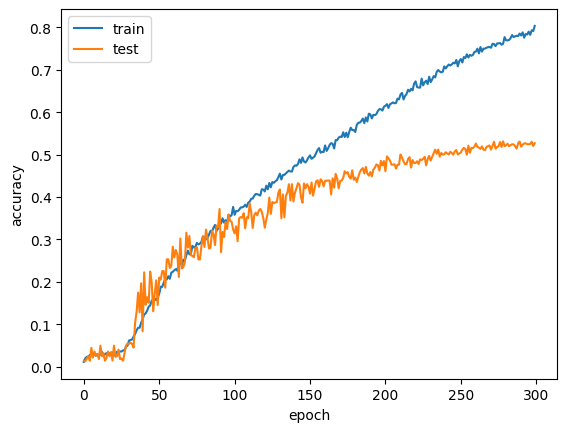

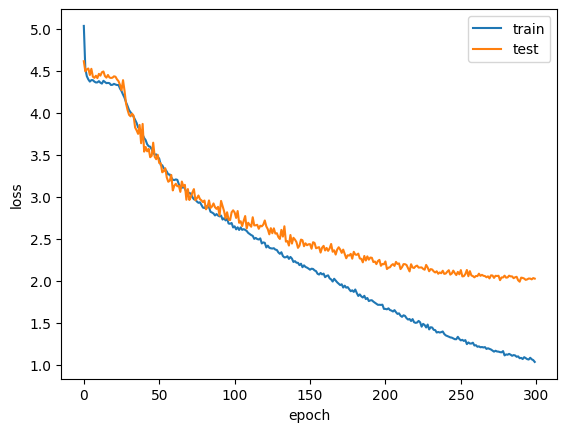

In [12]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [13]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_nCaltech101_ReLU1_ReLUmaxpool_EST_FC2_corrected_exp.csv')

In [14]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.011051,0.013785,5.037129,4.617019
1,0.019805,0.012636,4.527255,4.496220
2,0.022819,0.018955,4.438098,4.520441
3,0.023967,0.024124,4.400089,4.530379
4,0.027268,0.013785,4.374378,4.452902


In [15]:
df.tail()

,train_acc,test_acc,train_loss,test_loss
295,0.789897,0.524411,1.066336,2.030831
296,0.782290,0.524986,1.087394,2.029701
297,0.793197,0.530155,1.069053,2.020686
298,0.791188,0.520391,1.059568,2.035844
299,0.803387,0.526709,1.037892,2.029218


In [18]:
print(df.to_string())

     train_acc  test_acc  train_loss  test_loss
0     0.011051  0.013785    5.037129   4.617019
1     0.019805  0.012636    4.527255   4.496220
2     0.022819  0.018955    4.438098   4.520441
3     0.023967  0.024124    4.400089   4.530379
4     0.027268  0.013785    4.374378   4.452902
5     0.029277  0.044227    4.392316   4.526710
6     0.025689  0.021252    4.391397   4.433085
7     0.029994  0.035612    4.374368   4.418779
8     0.025545  0.025847    4.363949   4.444388
9     0.029851  0.029868    4.365312   4.415856
10    0.025689  0.017806    4.379865   4.466811
11    0.028703  0.049397    4.361135   4.445587
12    0.034874  0.024698    4.350462   4.485757
13    0.024397  0.031591    4.383968   4.494992
14    0.029277  0.013785    4.369509   4.440054
15    0.031716  0.020103    4.355781   4.421316
16    0.027411  0.035612    4.358879   4.453217
17    0.030855  0.024698    4.355608   4.423191
18    0.033008  0.033889    4.334409   4.417841
19    0.033295  0.014360    4.336229   4